In [ ]:
#!/usr/bin/env python3

import cv2
import csv
import numpy as np
import os
import requests
import random
import string
from PIL import Image, ImageFont, ImageDraw

# Constants
CURRENT_DIR = os.getcwd()
CLUE_BANNER_PATH = os.path.join(CURRENT_DIR, 'clue_banner.png')  # Ensure this file exists
OUTPUT_DIR = os.path.join(CURRENT_DIR, 'generated_plates')  # Directory for output plates
CLUES_CSV_PATH = os.path.join(CURRENT_DIR, 'plates.csv')  # Save the clues to CSV
FONT_PATH = os.path.join(CURRENT_DIR, 'UbuntuMono-R.ttf')  # Ensure this font file exists

# Function to load clues from the competition URL and generate random values
def load_clues():
    """
    Fetch clues from the competition URL and save them to plates.csv with random values.
    Returns:
        dict: A dictionary of clues (key-value pairs).
    """
    URL = "https://phas.ubc.ca/~miti/ENPH353/ENPH353Clues.csv"
    print("Loading clues from the URL...")
    
    response = requests.get(URL)
    if response.status_code != 200:
        raise Exception("Failed to load clues from the URL.")
    
    raw = response.text.strip().split('\n')
    key_list = raw[0].split(',')

    # Define ambiguous characters
    ambiguous_chars = ['O', '0', 'I', '1', 'Z', '2', 'B', '8', 'S', '5', 'G', '6', 'Y', 'V','Y', 'V','Y', 'V','Y', 'V','Y', 'V','Y', 'V', 'U', 'V', 'C', 'G','C', 'G','C', 'G','C', 'G','C', 'G','C', 'G','C', 'G','C', 'G','C', 'G','C', 'G','C', 'G','C', 'G','C', 'G','C', 'G', 'M', 'W', '7', '1', '9', '7', 'I', 'I','I','1','1','1','P','P','P','F','F','F','F','F','P']
    # ambiguous_chars = ['Y','V','Y','V','Y','V','Y','V','Y','V','Y','V','Y','V','Y','V','Y','V']
    # ambiguous_chars = ['G','G','G','G','G','G','G','G','C','C','C','C','C','C','C','C','C']
    all_chars = string.ascii_uppercase + string.digits
    # Bias the distribution towards ambiguous characters
    biased_chars = all_chars + ''.join(ambiguous_chars * 8)  # Repeat ambiguous characters to increase their likelihood

    # Generate random values and save to file
    clues = {}
    with open(CLUES_CSV_PATH, 'w') as plates_file:
        csvwriter = csv.writer(plates_file)
        for key in key_list:
            clues[key] = []
            for _ in range(500):  # Generate 50 random values per clue type
                length = random.randint(4, 12)
                # Generate random characters, ensuring no spaces at the start or end
                while True:
                    chars = [random.choice(biased_chars) for _ in range(length)]
                    if chars[0] != ' ' and chars[-1] != ' ':
                        break
                random_value = ''.join(chars)
                clues[key].append(random_value)
                csvwriter.writerow([key, random_value])

    print(f"Clues saved to: {CLUES_CSV_PATH}")
    return clues




# Function to generate clue plates with augmentations
def generate_clue_plates(clues, banner_path, output_dir):
    """
    Generate clue plates by overlaying text onto a clue banner image with added distortions, noise, and transformations.
    Args:
        clues (dict): Dictionary of clues (key-value pairs).
        banner_path (str): Path to the clue banner image.
        output_dir (str): Directory to save the generated clue plates.
    """
    # Load the clue banner image
    banner_canvas = cv2.imread(banner_path)
    if banner_canvas is None:
        raise FileNotFoundError(f"Clue banner image not found at {banner_path}")
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Font settings
    font_size = 90
    if not os.path.exists(FONT_PATH):
        raise FileNotFoundError(f"Font file not found at {FONT_PATH}. Ensure UbuntuMono-R.ttf is in the script directory.")
    monospace = ImageFont.truetype(FONT_PATH, font_size)
    font_color = (255, 0, 0)  # Red font

    # Generate and save plates
    plates_info = []  # To store plate info for verification
    for key, values in clues.items():
        for i, value in enumerate(values):
            print(f"Generating plate: {key}, {value}")
            
            # Convert the OpenCV image to a PIL image
            blank_plate_pil = Image.fromarray(banner_canvas)
            draw = ImageDraw.Draw(blank_plate_pil)

            # Overlay the text onto the banner
            draw.text((250, 30), key, font_color, font=monospace)  # Clue type
            draw.text((30, 250), value, font_color, font=monospace)  # Clue value

            # Convert back to OpenCV format
            populated_banner = np.array(blank_plate_pil)

            # Apply distortions, noise, and transformations
            augmented_banner = apply_augmentations(populated_banner)

            # Save the generated plate
            output_file = os.path.join(output_dir, f"plate_{i}_{key}_{value}.png")
            cv2.imwrite(output_file, augmented_banner)

            # Add plate info for verification
            plates_info.append({"index": i, "key": key, "value": value, "file": output_file})

    print(f"Generated plates saved to: {output_dir}")
    return plates_info

def apply_augmentations(image):
    """
    Apply distortions, noise, and transformations to the image.
    Args:
        image (np.ndarray): Input image.
    Returns:
        np.ndarray: Augmented image.
    """
    # Resize for better control
    height, width = image.shape[:2]

    # Add random noise
    noise = np.random.normal(0, 5, image.shape).astype(np.uint8)  # Gaussian noise
    image = cv2.add(image, noise)

    return image

# Function to visualize generated plates
def visualize_plates(plates_info):
    """
    Display generated plates for verification.
    Args:
        plates_info (list): List of dictionaries with plate info.
    """
    for plate in plates_info:
        img = cv2.imread(plate["file"])
        if img is None:
            print(f"Failed to load: {plate['file']}")
            continue

    cv2.destroyAllWindows()

# Main execution
if __name__ == "__main__":
    try:
        # Load clues
        clues = load_clues()

        # Generate clue plates
        plates_info = generate_clue_plates(clues, CLUE_BANNER_PATH, OUTPUT_DIR)

        # Visualize the generated plates for verification
        visualize_plates(plates_info)

    except Exception as e:
        print(f"Error: {e}")


Loading clues from the URL...
Clues saved to: /home/fizzer/Downloads/353/plates.csv
Generating plate: SIZE, ACCCCGCG
Generating plate: SIZE, CCGCGCI9C
Generating plate: SIZE, GCCGCCG
Generating plate: SIZE, CGGCVGGCCCGC
Generating plate: SIZE, CGCGGC
Generating plate: SIZE, CGCG
Generating plate: SIZE, C2GGGGGGGG
Generating plate: SIZE, CCCCCCCC
Generating plate: SIZE, GGGGGCCC
Generating plate: SIZE, GGGGW
Generating plate: SIZE, C9CCG
Generating plate: SIZE, GGCCCGCGCCG
Generating plate: SIZE, CCCC
Generating plate: SIZE, CGCACCGCGG
Generating plate: SIZE, CGCG0GGGGG
Generating plate: SIZE, CCCCGCEGGCCG
Generating plate: SIZE, GGIGGGC
Generating plate: SIZE, GGGCG
Generating plate: SIZE, CCGCGG
Generating plate: SIZE, CCGICC
Generating plate: SIZE, GCOCGG
Generating plate: SIZE, GGCCCG
Generating plate: SIZE, GCGCC
Generating plate: SIZE, CGCCCGC
Generating plate: SIZE, CCCC
Generating plate: SIZE, MC4GCGG
Generating plate: SIZE, CGKCMC
Generating plate: SIZE, CCGN
Generating plate: 

KeyboardInterrupt: 

In [7]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
import cv2
import numpy as np
import os
import logging
from PIL import ImageFont
import matplotlib.pyplot as plt

# Define constants
OUTPUT_DIR = "generated_plates"
CHARACTER_OUTPUT_DIR = "character_segments"
ROI_OUTPUT_DIR = "regions_of_interest"
os.makedirs(CHARACTER_OUTPUT_DIR, exist_ok=True)
os.makedirs(ROI_OUTPUT_DIR, exist_ok=True)

label_output_file = "character_labels.csv"
FONT_PATH = "UbuntuMono-R.ttf"  # Ensure this font file exists in the script directory
FONT_SIZE = 90  # Font size used in the plate generation
def apply_augmentations(image):
    """
    Apply random augmentations to the image for variance.
    Args:
        image (numpy.ndarray): Input binary image.
    Returns:
        numpy.ndarray: Augmented image.
    """
    # Scale the image
    scale_factor_x = np.random.uniform(0.9, 1.1)
    scale_factor_y = np.random.uniform(0.9, 1.5)
    scaled = cv2.resize(image, None, fx=scale_factor_x, fy=scale_factor_y, interpolation=cv2.INTER_LINEAR)

    # Rotate the image
    angle = np.random.uniform(-1, 1)  # Random angle between -10 and 10 degrees
    h, w = scaled.shape
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(scaled, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    # Add perspective distortion
    h, w = rotated.shape
    src_pts = np.float32([[0, 0], [w - 1, 0], [0, h - 1], [w - 1, h - 1]])
    dst_pts = src_pts + np.random.uniform(-5, 5, src_pts.shape).astype(np.float32)

    # Ensure points are within bounds
    dst_pts[:, 0] = np.clip(dst_pts[:, 0], 0, w - 1)
    dst_pts[:, 1] = np.clip(dst_pts[:, 1], 0, h - 1)

    # Verify that the points have the correct shape
    if src_pts.shape == (4, 2) and dst_pts.shape == (4, 2):
        try:
            perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
            distorted = cv2.warpPerspective(rotated, perspective_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        except cv2.error as e:
            logging.error(f"Perspective transformation failed: {e}")
            distorted = rotated
    else:
        logging.warning("Invalid perspective points detected. Skipping perspective distortion.")
        distorted = rotated

    return distorted



def preprocess_image(image):
    """
    Preprocess the input image to clean noise and prepare it for character segmentation.
    Args:
        image (numpy.ndarray): Grayscale input image.
    Returns:
        numpy.ndarray: Binary image after preprocessing.
    """
    # Apply Gaussian Blur to reduce noise and improve thresholding results
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Adaptive thresholding for uneven lighting
    binary = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 9, 5
    )

    # Morphological operations to clean noise and connect broken parts
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return binary

def extract_regions_of_interest(plate_img):
    """
    Extracts the top-right and bottom regions of the plate image.
    Args:
        plate_img (numpy.ndarray): The full plate image.
    Returns:
        tuple: (top_right_region, bottom_region) as numpy arrays.
    """
    h, w = plate_img.shape[:2]

    # Define ROIs
    top_right_region = plate_img[:h // 3, (2 * w) // 5:]  # Top third and right two-fifths
    bottom_region = plate_img[h // 2:, :]  # Bottom half

    return top_right_region, bottom_region

def segment_characters(image, expected_label, region_name, filename, label_output_file):
    # Preprocess the image
    binary = preprocess_image(image)

    # Load the font to get character width
    monospace_font = ImageFont.truetype(FONT_PATH, FONT_SIZE)
    char_width, _ = monospace_font.getsize("A")
    total_text_width, _ = monospace_font.getsize(expected_label)

    # Calculate scaling factor based on text region
    vertical_sum = np.sum(binary, axis=0)
    non_zero_columns = np.where(vertical_sum > 0)[0]

    if non_zero_columns.size > 0:
        text_start = non_zero_columns[0]
        text_end = non_zero_columns[-1]
        text_width = text_end - text_start + 1
    else:
        text_start = 0
        text_end = image.shape[1] - 1
        text_width = image.shape[1]

    scale_factor = text_width / total_text_width
    adjusted_char_width = int(char_width * scale_factor)

    # Build bounding boxes
    bounding_boxes = []
    x_offset = text_start
    for i in range(len(expected_label)):
        x = x_offset
        w = adjusted_char_width
        if x + w > text_end:
            w = text_end - x + 1
        bounding_boxes.append((x, 0, w, image.shape[0]))
        x_offset += w

    # Proceed with character extraction and saving
    segments = []
    for i, (x, y, w, h) in enumerate(bounding_boxes):
        segment = binary[y:y+h, x:x+w]
        segments.append((i, x, y, w, h, segment))

    # Mismatch detection
    if len(segments) != len(expected_label):
        logging.warning(f"Mismatch in character count for {filename} ({region_name}). "
                        f"Expected {len(expected_label)}, found {len(segments)}.")

    # Loop through each segment
    for i, (index, x, y, w, h, segment) in enumerate(segments):
        # Apply augmentations
        augmented_segment = apply_augmentations(segment)

        # Resize to standard size for the model
        char_img = cv2.resize(augmented_segment, (28, 28))

        # Save the character image
        char_filename = f"{filename}_{region_name}_char_{i}.png"
        char_filepath = os.path.join(CHARACTER_OUTPUT_DIR, char_filename)
        cv2.imwrite(char_filepath, char_img)

        # Save the label to the CSV
        with open(label_output_file, "a") as f:
            label = expected_label[i] if i < len(expected_label) else '?'
            f.write(f"{char_filepath},{label}\n")



# Main processing loop
for filename in os.listdir(OUTPUT_DIR):
    if filename.endswith(".png"):
        try:
            plate_path = os.path.join(OUTPUT_DIR, filename)
            plate_img = cv2.imread(plate_path, cv2.IMREAD_GRAYSCALE)
            if plate_img is None:
                logging.error(f"Failed to load image: {filename}")
                continue

            # Extract ROIs
            top_right_region, bottom_region = extract_regions_of_interest(plate_img)

            # Save the extracted regions of interest
            top_right_filename = f"{filename}_top_right.png"
            bottom_filename = f"{filename}_bottom.png"
            top_right_filepath = os.path.join(ROI_OUTPUT_DIR, top_right_filename)
            bottom_filepath = os.path.join(ROI_OUTPUT_DIR, bottom_filename)
            cv2.imwrite(top_right_filepath, top_right_region)
            cv2.imwrite(bottom_filepath, bottom_region)

            # Get labels from the filename
            try:
                top_label = filename.split("_")[2]  # Clue type, may contain spaces
                bottom_label = filename.split("_")[3].split(".")[0]  # Clue value, may contain spaces
            except IndexError:
                logging.warning(f"Filename format error: {filename}")
                continue

            # Segment characters for each region
            segment_characters(top_right_region, top_label, "top", filename, label_output_file)
            segment_characters(bottom_region, bottom_label, "bottom", filename, label_output_file)

        except Exception as e:
            logging.error(f"Error processing file {filename}: {e}")


In [1]:
%pip install numpy tensorflow pandas

  Using cached tensorflow-2.18.0-cp310-cp310-win_amd64.whl (7.5 kB)
  Using cached tensorflow_intel-2.18.0-cp310-cp310-win_amd64.whl (390.0 MB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
  Using cached ml_dtypes-0.4.1-cp310-cp310-win_amd64.whl (126 kB)
  Using cached h5py-3.12.1-cp310-cp310-win_amd64.whl (3.0 MB)
  Using cached protobuf-5.28.3-cp310-abi3-win_amd64.whl (431 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl (1.5 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached wrapt-1.17.0-cp310-cp310-win_amd64.whl (38 kB)
  Using cached numpy-2.0.2-cp310-cp310-win_amd64.whl (15.9 MB)
  Using cached grpcio-1.68.0-cp310-cp310-win_amd64.whl (4.4 MB)
  Using cached termcolor-2.5.0-py3-none-any.whl (7.8 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\rober\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_character_cnn_model(num_classes):
    model = Sequential([
        # Convolutional layers
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Fully connected layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # One class per character
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [27]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\rober\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import string

# Define LABELS consistently
LABELS = string.ascii_uppercase + string.digits  # 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

# Load the CSV file containing character image paths and labels
label_output_file = "character_labels.csv"
df = pd.read_csv(label_output_file, header=None, names=['filepath', 'label'])

# Load the images and labels
images = []
labels = []

for index, row in df.iterrows():
    # Load the character image (grayscale)
    img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
    if img is not None and row['label'] in LABELS:
        # Normalize the image to range [0, 1]
        img = img.astype('float32') / 255.0
        # Expand dimensions to match input shape for CNN (28, 28, 1)
        img = np.expand_dims(img, axis=-1)
        images.append(img)
        labels.append(row['label'])  # Ensure label is valid

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Create label mapping using LABELS
label_dict = {char: idx for idx, char in enumerate(LABELS)}
numeric_labels = np.array([label_dict[label] for label in labels])

# One-hot encode the labels using `to_categorical`
num_classes = len(LABELS)
labels_one_hot = to_categorical(numeric_labels, num_classes=num_classes)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images, labels_one_hot, test_size=0.2, random_state=42
)

# Create the character recognition CNN model
def create_character_cnn_model(num_classes):
    model = Sequential([
        # Convolutional layers
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Fully connected layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # One class per character
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the model
model = create_character_cnn_model(num_classes=num_classes)

# Train the model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, 
    batch_size=32
)

# Save the trained model
model.save("character_recognition_model.h5")


Epoch 1/15
28547/28547 [==============================] - 135s 5ms/step - loss: 0.0932 - accuracy: 0.9705 - val_loss: 0.0065 - val_accuracy: 0.9977
Epoch 2/15
28547/28547 [==============================] - 135s 5ms/step - loss: 0.0197 - accuracy: 0.9933 - val_loss: 0.0046 - val_accuracy: 0.9981
Epoch 3/15
28547/28547 [==============================] - 132s 5ms/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.0022 - val_accuracy: 0.9989
Epoch 4/15
28547/28547 [==============================] - 134s 5ms/step - loss: 0.0127 - accuracy: 0.9959 - val_loss: 0.0035 - val_accuracy: 0.9985
Epoch 5/15
28547/28547 [==============================] - 135s 5ms/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 0.0024 - val_accuracy: 0.9990
Epoch 6/15
28547/28547 [==============================] - 133s 5ms/step - loss: 0.0116 - accuracy: 0.9965 - val_loss: 0.0040 - val_accuracy: 0.9988
Epoch 7/15
28547/28547 [==============================] - 134s 5ms/step - loss: 0.0108 - accuracy: 0.9968 - val_

3569/3569 [==============================] - 8s 2ms/step


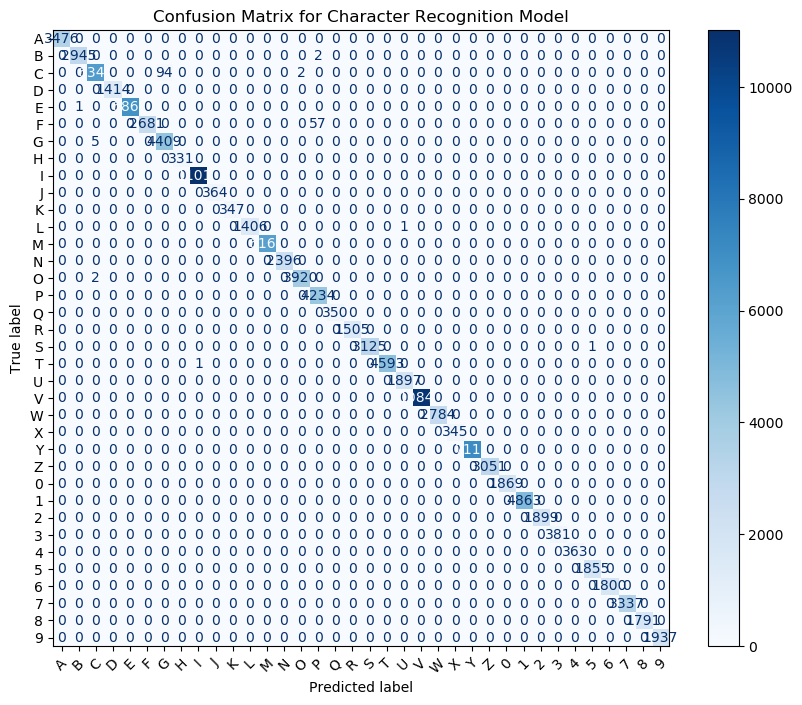

InvalidParameterError: The 'target_names' parameter of classification_report must be an array-like or None. Got 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789' instead.

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Step 1: Make predictions
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Convert one-hot encoded labels back to class indices
y_true = np.argmax(y_val, axis=1)

# Step 3: Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.xticks(rotation=45)
plt.title("Confusion Matrix for Character Recognition Model")
plt.show()

# Optionally print a classification report for additional metrics
print(classification_report(y_true, y_pred, target_names=LABELS))


In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import string

# Define LABELS
LABELS = string.ascii_uppercase + string.digits

# Load the model
model = load_model('character_recognition_model.h5')

# Load and preprocess a test image
test_image = cv2.imread('test_char.png', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (28, 28))
test_image = test_image.astype('float32') / 255.0
test_image = np.expand_dims(test_image, axis=-1)  # Add channel dimension
test_image = np.expand_dims(test_image, axis=0)   # Add batch dimension

# Predict
prediction = model.predict(test_image)
predicted_char = LABELS[np.argmax(prediction)]
print(f"Predicted character: {predicted_char}")


1/1 [==============================] - 0s 41ms/step
Predicted character: 7
